# N01. Redes Bayesianas

__Manuel Mateo Delgado, Computación Inteligente y Ética de la IA. Curso 2024__


## Preámbulo

En este _notebook_ se afrontará un ejemplo sencillo de una red bayesiana. Se trata de un caso de estudio en el que se pretende modelar la probabilidad de que un paciente tenga una enfermedad en función de los síntomas que presenta.

Las redes bayesianas son un tipo de modelo gráfico probabilístico que permite representar de forma compacta y eficiente las relaciones de dependencia entre variables aleatorias. En este caso, se pretende modelar la probabilidad de que un paciente tenga una enfermedad en función de los síntomas que presenta. La enfermedad y los síntomas son variables aleatorias, y la red bayesiana permite representar las relaciones de dependencia entre ellas.

### Formulación del problema

> A patient has been suffering from shortness of breath (called dyspnoea) and visits the doctor, worried that he has lung cancer. The doctor knows that other diseases, such as tuberculosis and bronchitis, are possible causes, as well as lung cancer. She also knows that other relevant information includes whether or not the patient is a smoker (increasing the chances of cancer and bronchitis) and what sort of air pollution he has been exposed to. A positive X-ray would indicate either TB or lung cancer. [Korb, K. B., & Nicholson, A. E. (2023). Bayesian Artificial Intelligence. CRC Press]

Así pues, tenemos las siguientes variables aleatorias:

- `C`: cáncer de pulmón.
- `D`: disnea (dificultad para respirar), síntoma común a varias enfermedades.
- `F`: paciente fumador.
- `P`: exposición a la contaminación del aire (polución).
- `X`: radiografía positiva (indica tuberculosis o cáncer de pulmón).
- `B`: prueba de biopsia

La red bayesiana que modela estas relaciones es la siguiente, según el razonamiento del experto médico:


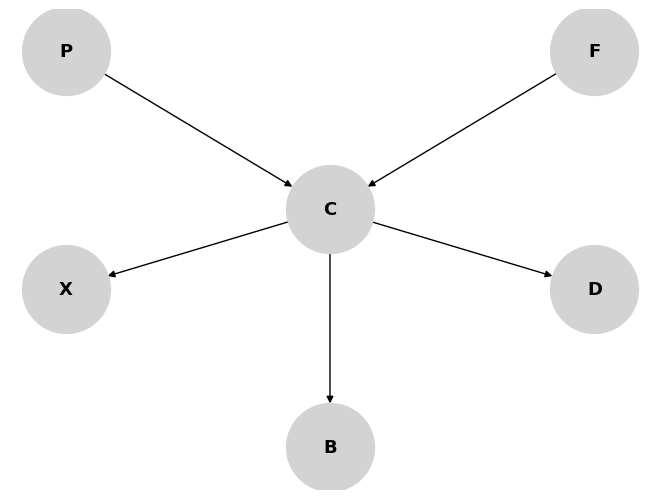

In [53]:
# Representación de la red bayesiana como grafo con la librería NetworkX

import networkx as nx

dag_red = nx.DiGraph(
    nodos_red := [
        ("P", "C"),
        ("F", "C"),
        ("C", "X"),
        ("C", "D"),
        ("C", "B"),
    ]
)

# Dibujar el grafo. Primera fila, `P` y `F`; segunda fila, `E`; tercera fila, `X` y `D`
nx.draw(
    dag_red,
    with_labels=True,
    node_color="lightgray",
    node_size=4000,
    font_size=13,
    font_color="black",
    font_weight="bold",
    pos={"X": (0, 0), "D": (1, 0), "C": (0.5, 0.5), "P": (0, 1.5), "F": (1, 1.5), "B": (0.5, -1)},
)

Los posibles valores de los nodos son:

| Nodo | Valores    |
|------|------------|
|  C   | no, sí     |
|  D   | no, sí     |
|  F   | no, sí     |
|  P   | baja, alta |
|  X   | no, sí     |
|  B   | no, sí |

Se sabe lo siguiente sobre las relaciones de probabilidad condicionada entre las variables:

- La probabilidad de haber estado expuesto a una alta contaminación del aire es del 10 %.
- La probabilidad de haber estado expuesto a una baja contaminación del aire es del 90 %.
- La probabilidad de que un paciente sea fumador es del 30 %.
- La probabilidad de que un paciente no sea fumador es del 70 %.
- La probabilidad de que una prueba de rayos X sea positiva si el paciente tiene cáncer de pulmón es del 90 %.
- La probabilidad de que una prueba de rayos X sea negativa si el paciente tiene cáncer de pulmón es del 20 %.
- La probabilidad de que un paciente padezca disnea si tiene cáncer de pulmón es del 65 %.
- La probabilidad de que un paciente no padezca disnea si tiene cáncer de pulmón es del 30 %.
- La probabilidad de que un paciente tenga cáncer de pulmón si es fumador y ha estado expuesto a una alta contaminación del aire es del 5 %.
- La probabilidad de que un paciente tenga cáncer de pulmón si es fumador y ha estado expuesto a una baja contaminación del aire es del 3 %.
- La probabilidad de que un paciente tenga cáncer de pulmón si no es fumador y ha estado expuesto a una alta contaminación del aire es del 2 %.
- La probabilidad de que un paciente tenga cáncer de pulmón si no es fumador y ha estado expuesto a una baja contaminación del aire es del 0,1 %.
- La probabilidad de que una prueba de biopsia sea positiva si el paciente tiene cáncer de pulmón es del 98 %.
- La probabilidad de que una prueba de biopsia sea negativa si el paciente tiene cáncer de pulmón es del 5 %.


## Ej. 1. Modelado de la red bayesiana

Se pide modelar la red bayesiana en Python, utilizando la librería `pgmpy`.

`pgmpy` es una librería de Python para modelado y aprendizaje de redes bayesianas. Permite la creación de redes bayesianas, la inferencia y el aprendizaje de parámetros. Es una librería avanzada, que en este _notebook_ sólo se utilizará someramente para este sencillo ejemplo.

In [54]:
import pgmpy.models as pgm

### Nodos

In [55]:
# Se añaden los mismos nodos que en el grafo superior
red = pgm.BayesianNetwork(nodos_red)

print(red.nodes())

['P', 'C', 'F', 'X', 'D', 'B']


### DPC (distribución de probabilidad condicionada)

Las variables aleatorias de la red bayesiana se relacionan mediante la distribución de probabilidad condicionada (DPC). La DPC de una variable aleatoria es la probabilidad de que tome un valor dado el valor de sus padres en la red bayesiana. En inglés, la DPC se llama _conditional probability distribution_ (CPD).

In [56]:
# Hay definir la DPC de cada nodo
import pgmpy.factors.discrete as pgmf

dpc_p = pgmf.TabularCPD(
    variable="P",
    variable_card=2,  # Número de valores posibles que puede tomar una variable en la red bayesiana
    values=[
        [0.9],
        [0.1],
    ],  # Probabilidad de que la variable `P` tome el valor `baja` o `alta`
    state_names={"P": ["baja", "alta"]},
)
print(dpc_p)

dpc_f = pgmf.TabularCPD(
    variable="F",
    variable_card=2,
    values=[[0.3], [0.7]],
    state_names={"F": ["sí", "no"]},
)
print(dpc_f)

+---------+-----+
| P(baja) | 0.9 |
+---------+-----+
| P(alta) | 0.1 |
+---------+-----+
+-------+-----+
| F(sí) | 0.3 |
+-------+-----+
| F(no) | 0.7 |
+-------+-----+


In [57]:
from typing import List


def prob_complementaria(probs: List[float]):
    """
    Funciión auxiliar que, dado una lista de probabilidades, devuelve el complemento de cada una de ellas.
    """
    # return [1 - prob for prob in probs] # Compresión de lista equivalente a la siguiente forma

    probs_comp = []
    for prob in probs:
        probs_comp.append(1 - prob)

    return probs_comp

In [58]:
dpc_c = pgmf.TabularCPD(
    variable="C",
    variable_card=2,
    values=[probs := [0.03, 0.001, 0.05, 0.02], prob_complementaria(probs)],
    evidence=["P", "F"],  # Variables que influyen en la variable `C`
    evidence_card=[2, 2],
    state_names={"C": ["sí", "no"], "P": ["baja", "alta"], "F": ["sí", "no"]},
)
print(dpc_c)

dpc_x = pgmf.TabularCPD(
    variable="X",
    variable_card=2,
    values=[probs := [0.9, 0.2], prob_complementaria(probs)],
    evidence=["C"],
    evidence_card=[2],
    state_names={"X": ["sí", "no"], "C": ["sí", "no"]},
)
print(dpc_x)

dpc_d = pgmf.TabularCPD(
    variable="D",
    variable_card=2,
    values=[probs := [0.65, 0.3], prob_complementaria(probs)],
    evidence=["C"],
    evidence_card=[2],
    state_names={"D": ["sí", "no"], "C": ["sí", "no"]},
)
print(dpc_d)

dcp_b = pgmf.TabularCPD(
    variable="B",
    variable_card=2,
    values=[probs := [0.98, 0.05], prob_complementaria(probs)],
    evidence=["C"],
    evidence_card=[2],
    state_names={"B": ["sí", "no"], "C": ["sí", "no"]},
)
print(dcp_b)

+-------+---------+---------+---------+---------+
| P     | P(baja) | P(baja) | P(alta) | P(alta) |
+-------+---------+---------+---------+---------+
| F     | F(sí)   | F(no)   | F(sí)   | F(no)   |
+-------+---------+---------+---------+---------+
| C(sí) | 0.03    | 0.001   | 0.05    | 0.02    |
+-------+---------+---------+---------+---------+
| C(no) | 0.97    | 0.999   | 0.95    | 0.98    |
+-------+---------+---------+---------+---------+
+-------+---------------------+-------+
| C     | C(sí)               | C(no) |
+-------+---------------------+-------+
| X(sí) | 0.9                 | 0.2   |
+-------+---------------------+-------+
| X(no) | 0.09999999999999998 | 0.8   |
+-------+---------------------+-------+
+-------+-------+-------+
| C     | C(sí) | C(no) |
+-------+-------+-------+
| D(sí) | 0.65  | 0.3   |
+-------+-------+-------+
| D(no) | 0.35  | 0.7   |
+-------+-------+-------+
+-------+----------------------+-------+
| C     | C(sí)                | C(no) |
+-----

### Creación del modelo

Una vez creados los nodos y las DPC, se ensamblan en un modelo de red bayesiana.

In [59]:
# Asignar las probabilidades condicionales al modelo
red.add_cpds(dpc_p, dpc_f, dpc_c, dpc_x, dpc_d, dcp_b)

# Verificar si el modelo es válido
assert red.check_model()

## Ej. 2. Inferencia en la red bayesiana

Una vez creada la red bayesiana, se puede emplear para hacer inferencias. Por ejemplo, se puede preguntar por la probabilidad de que un paciente tenga cáncer de pulmón dado que es fumador y ha estado expuesto a una alta contaminación del aire, o cualquier otra combinación dada.

In [60]:
from pgmpy.inference import (  # Algoritmo de eliminación de variables, para hacer inferencia en la red bayesiana. No aplica el detalle a este respecto
    VariableElimination,
)

In [61]:
# Crear un objeto motor de inferencia
infer = VariableElimination(red)

In [62]:
# Calcular la probabilidad de que un paciente tenga cáncer si sólo se conoce que padece disnea
res = infer.query(variables=["C"], evidence={"D": "sí"})
print(res)

+-------+----------+
| C     |   phi(C) |
+=======+==========+
| C(sí) |   0.0249 |
+-------+----------+
| C(no) |   0.9751 |
+-------+----------+


In [63]:
# Calcular la probabilidad de que un paciente fumador tenga cáncer
res = infer.query(variables=["C"], evidence={"F": "sí"})
print(res)

+-------+----------+
| C     |   phi(C) |
+=======+==========+
| C(sí) |   0.0320 |
+-------+----------+
| C(no) |   0.9680 |
+-------+----------+


In [64]:
# Calcular la probabilidad de que un paciente fumador tenga cáncer, habiendo estado expuesto a una baja contaminación del aire
res = infer.query(variables=["C"], evidence={"F": "sí", "P": "baja"})
print(res)

+-------+----------+
| C     |   phi(C) |
+=======+==========+
| C(sí) |   0.0300 |
+-------+----------+
| C(no) |   0.9700 |
+-------+----------+


In [65]:
# Calcular la probabilidad de que un paciente no fumador tenga cáncer, habiendo estado expuesto a una baja contaminación del aire
res = infer.query(variables=["C"], evidence={"F": "no", "P": "baja"})
print(res)

+-------+----------+
| C     |   phi(C) |
+=======+==========+
| C(sí) |   0.0010 |
+-------+----------+
| C(no) |   0.9990 |
+-------+----------+


In [66]:
# Calcular la probabilidad de que un paciente fumador tenga cáncer, habiendo estado expuesto a una alta contaminación del aire, y habiendo dado positivo en la prueba de rayos X
res = infer.query(variables=["C"], evidence={"F": "sí", "P": "alta", "X": "sí"})
print(res)

+-------+----------+
| C     |   phi(C) |
+=======+==========+
| C(sí) |   0.1915 |
+-------+----------+
| C(no) |   0.8085 |
+-------+----------+


In [67]:
# Ídem que el caso anterior, pero el paciente también padece de disnea
res = infer.query(variables=["C"], evidence={"F": "sí", "P": "alta", "X": "sí", "D": "sí"})
print(res)

+-------+----------+
| C     |   phi(C) |
+=======+==========+
| C(sí) |   0.3391 |
+-------+----------+
| C(no) |   0.6609 |
+-------+----------+


In [68]:
# Paciente fumador que da positivo en la preuba de biopsia
res = infer.query(variables=["C"], evidence={"F": "sí", "B": "sí"})
print(res)

+-------+----------+
| C     |   phi(C) |
+=======+==========+
| C(sí) |   0.3932 |
+-------+----------+
| C(no) |   0.6068 |
+-------+----------+
